# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета. 

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

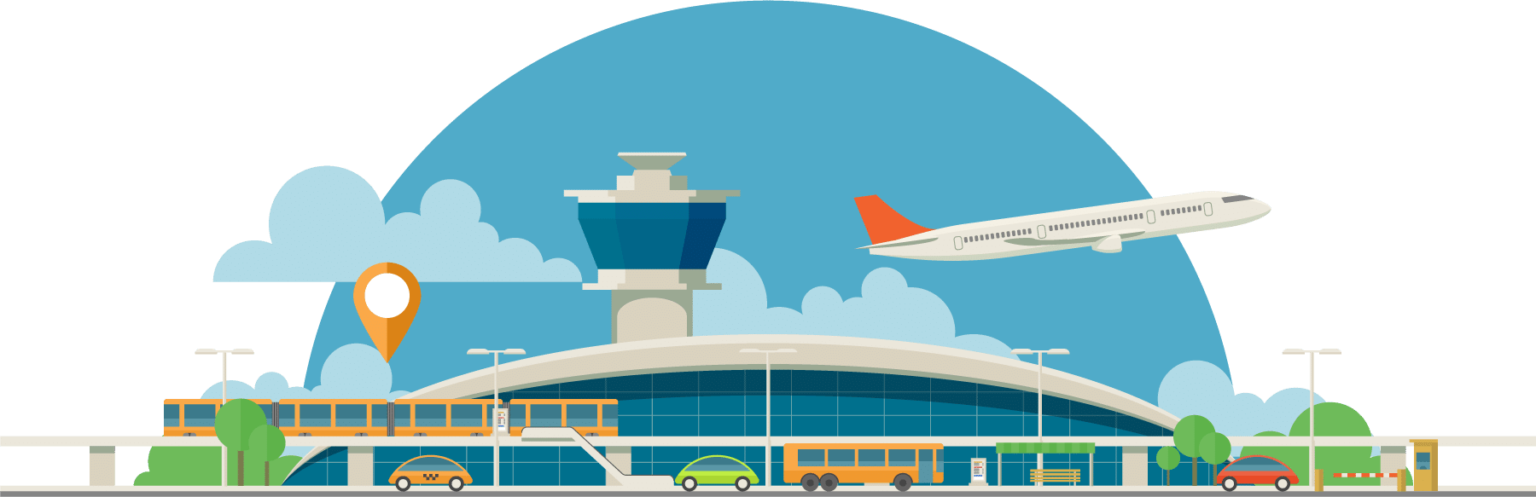

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [6]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
# !pip install xgboost
# !brew install cmake libomp
# !pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.5 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1


In [1]:
import pandas as pd
# import pandas.io.sql as psql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions 
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)


# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

In [17]:
!mkdir -p ~/.postgresql && \
    wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
        --output-document ~/.postgresql/root.crt && \
            chmod 600 ~/.postgresql/root.crt

--2023-12-27 19:54:39--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Распознаётся storage.yandexcloud.net (storage.yandexcloud.net)… 2a02:6b8::1d9, 213.180.193.243
Подключение к storage.yandexcloud.net (storage.yandexcloud.net)|2a02:6b8::1d9|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 3579 (3,5K) [application/x-x509-ca-cert]
Сохранение в: «/Users/ivyuminov/.postgresql/root.crt»

/Users/ivyuminov/.p 100%[===================>]   3,50K  --.-KB/s    за 0s      

2023-12-27 19:54:41 (3,33 GB/s) - «/Users/ivyuminov/.postgresql/root.crt» сохранён [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно. 

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

In [2]:
connect = psycopg2.connect(
    host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    port="6432",
    sslmode="verify-full",
    dbname="db_flights", 
    user="mlhs_student", 
    password="mlhs_student",
    target_session_attrs="read-write"
    )

print("Подключение установлено")

df = pd.io.sql.read_sql_query(
    '''SELECT clients_flight_info.id, clients_flight_info."Customer Type", 
    clients_flight_info."Type of Travel", clients_flight_info.class, 
    clients_flight_info."Flight Distance", clients_flight_info."Departure Delay in Minutes", 
    clients_flight_info."Arrival Delay in Minutes", 
    clients_marks."Inflight wifi service", 
    clients_marks."Departure/Arrival time convenient", clients_marks."Ease of Online booking", 
    clients_marks."Gate location", clients_marks."Food and drink", 
    clients_marks."Online boarding", clients_marks."Seat comfort", 
    clients_marks."Inflight entertainment", clients_marks."On-board service", 
    clients_marks."Leg room service", clients_marks."Baggage handling", 
    clients_marks."Checkin service", clients_marks."Inflight service", 
    clients_marks.cleanliness, clients_marks.satisfaction, 
    clients_bio.gender, clients_bio.age
    FROM public.clients_flight_info 
    JOIN public.clients_marks ON clients_marks.id = public.clients_flight_info.id 
    JOIN public.clients_bio ON clients_bio.id = public.clients_flight_info.id''', 
    connect
    ).set_index('id')

connect.close()

df.to_csv('clients_flight_info.csv')

Подключение установлено


pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write
```

### Схема БД

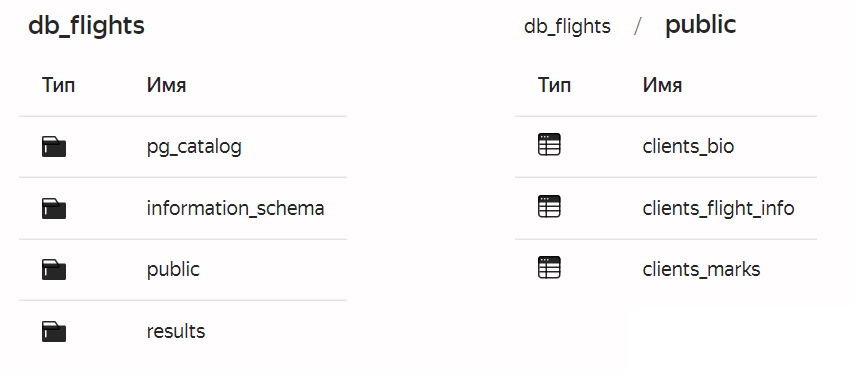

In [14]:
# df = pd.read_csv('clients_flight_info.csv').set_index('id')

In [15]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [54]:
# поверяю действительные типы данных в колонкаx df, меняю на float, где применимо
def change_columns_type(data):

    dict_type_data = dict()
    for i in data.columns:
        try:
            element = data[i][1]
            element_float = float(element)
            dict_type_data[i] = type(element_float)
            data[i] = data[i].astype(float)
        except:
            dict_type_data[i] = type(data[i][1])

    return dict_type_data

dict_type_df = change_columns_type(df)

(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

<Axes: >

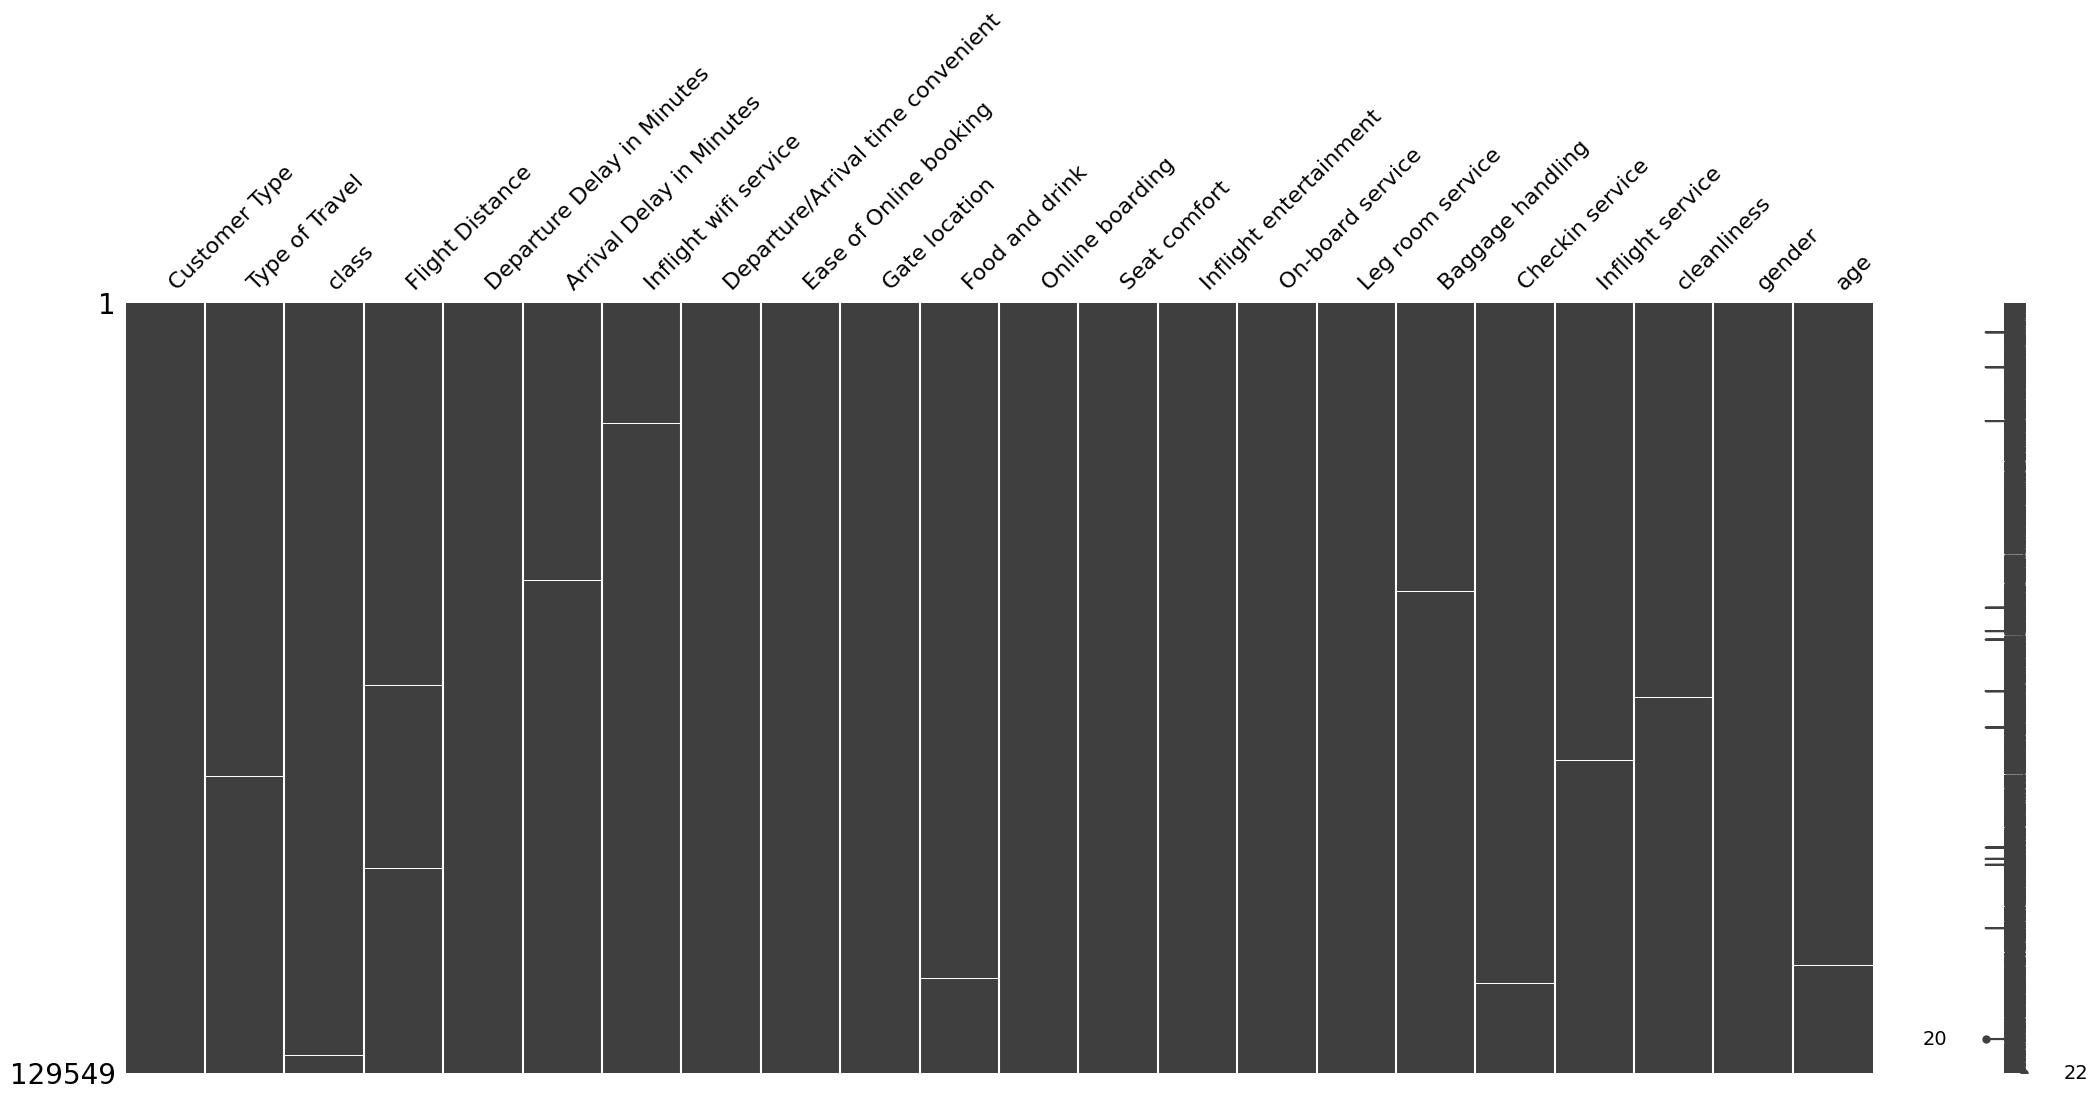

In [25]:
missingno.matrix(df.drop('satisfaction', axis='columns'))

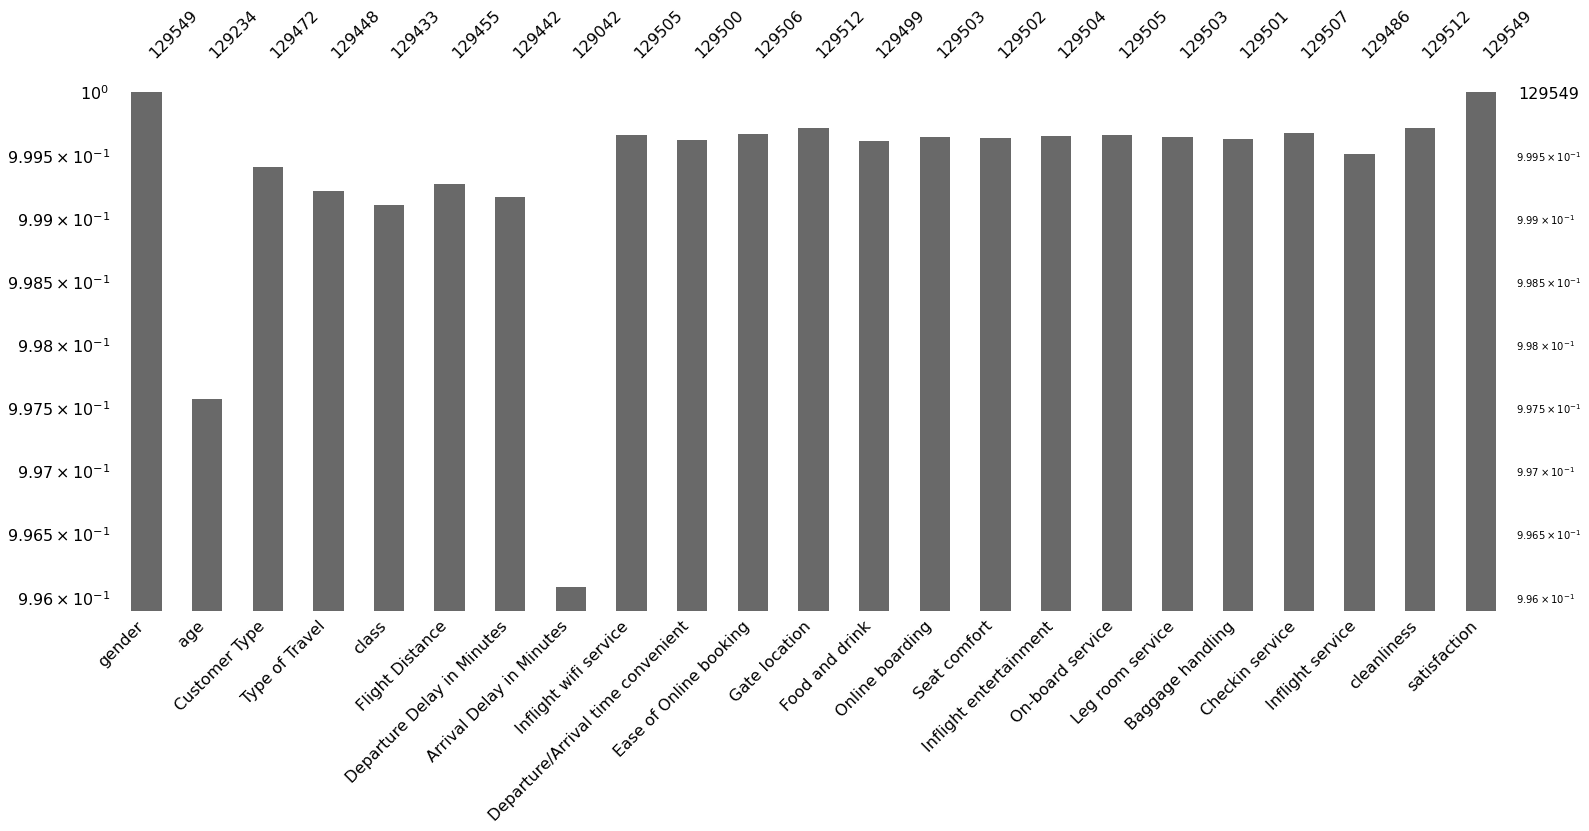

In [ ]:
missingno.bar(df.drop('satisfaction', axis='columns'), log=True, sort="descending")

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [30]:
df_train = df[df.satisfaction != '-']
df_train

Customer Type   Type of Travel     class  Flight Distance  \
id                                                                      
7          Loyal Customer  Business travel  Business           1963.0   
13      disloyal Customer  Business travel       Eco            453.0   
18         Loyal Customer  Personal Travel       Eco            821.0   
31      disloyal Customer  Business travel  Business            212.0   
39         Loyal Customer  Business travel  Business             67.0   
...                   ...              ...       ...              ...   
129831     Loyal Customer  Personal Travel       Eco            447.0   
129837     Loyal Customer  Personal Travel       Eco            337.0   
129838     Loyal Customer  Personal Travel       Eco            308.0   
129839     Loyal Customer  Personal Travel       Eco            337.0   
129846     Loyal Customer  Personal Travel       Eco            447.0   

        Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                             
7                              0.0                       0.0   
13                            16.0                      30.0   
18                             0.0                       0.0   
31                             0.0                       0.0   
39                             0.0                       0.0   
...                            ...                       ...   
129831                        23.0                      16.0   
129837                       199.0                     213.0   
129838                        32.0                      24.0   
129839                         0.0                       0.0   
129846                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
7                         3.0                                3.0   
13                        2.0                                2.0   
18                        2.0                                5.0   
31                        2.0                                2.0   
39                        3.0                                3.0   
...                       ...                                ...   
129831                    1.0                                3.0   
129837                    2.0                                4.0   
129838                    3.0                                5.0   
129839                    2.0                                4.0   
129846                    2.0                                5.0   

        Ease of Online booking  Gate location  ...  Inflight entertainment  \
id                                             ...                           
7                          3.0            3.0  ...                     5.0   
13                         2.0            4.0  ...                     5.0   
18                         2.0            1.0  ...                     5.0   
31                         2.0            1.0  ...                     2.0   
39                         3.0            3.0  ...                     4.0   
...                        ...            ...  ...                     ...   
129831                     1.0            5.0  ...                     3.0   
129837                     2.0            3.0  ...                     5.0   
129838                     3.0            4.0  ...                     3.0   
129839                     2.0            3.0  ...                     3.0   
129846                     2.0            3.0  ...                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13                   2.0               4.0               4.0              2.0   
18   

In [31]:
assert df_train.shape == (103_644, 23)

In [32]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

Customer Type   Type of Travel     class  Flight Distance  \
id                                                                   
55      Loyal Customer  Business travel  Business           3655.0   
79      Loyal Customer  Personal Travel       Eco            108.0   
126     Loyal Customer  Personal Travel       Eco            562.0   
199     Loyal Customer  Business travel  Business           3756.0   
263     Loyal Customer  Personal Travel  Business            802.0   
...                ...              ...       ...              ...   
129750  Loyal Customer  Business travel       Eco            337.0   
129771  Loyal Customer  Personal Travel       Eco            308.0   
129798  Loyal Customer  Personal Travel       Eco            308.0   
129868  Loyal Customer  Business travel  Eco Plus            447.0   
129876  Loyal Customer  Personal Travel  Eco Plus            447.0   

        Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                             
55                            40.0                      71.0   
79                            50.0                      41.0   
126                           88.0                      84.0   
199                           36.0                      24.0   
263                            0.0                       0.0   
...                            ...                       ...   
129750                        92.0                      82.0   
129771                         2.0                       0.0   
129798                         0.0                       0.0   
129868                         0.0                       0.0   
129876                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
55                        1.0                                1.0   
79                        5.0                                4.0   
126                       2.0                                5.0   
199                       4.0                                4.0   
263                       1.0                                2.0   
...                       ...                                ...   
129750                    4.0                                3.0   
129771                    3.0                                4.0   
129798                    2.0                                4.0   
129868                    3.0                                4.0   
129876                    4.0                                4.0   

        Ease of Online booking  Gate location  ...  Seat comfort  \
id                                             ...                 
55                         1.0            1.0  ...           3.0   
79                         0.0            3.0  ...           4.0   
126                        2.0            4.0  ...           5.0   
199                        4.0            4.0  ...           5.0   
263                        1.0            3.0  ...           3.0   
...                        ...            ...  ...           ...   
129750                     3.0            3.0  ...           4.0   
129771                     3.0            3.0  ...           5.0   
129798                     2.0            2.0  ...           5.0   
129868                     4.0            4.0  ...           4.0   
129876                     4.0            2.0  ...           1.0   

        Inflight entertainment  On-board service  Leg room service  \
id                                                                   
55                         3.0               3.0               3.0   
79                         3.0               3.0               0.0   
126                        5.0               3.0               5.0   
199                        4.0               4.0               4.0   
263                        2.0               2.0               1.0   
...  

In [33]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [34]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [35]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые. 

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [111]:
def fill_null_data(data, data_fill_null):
    
    '''
    data - данные по которым вычисляется значение для заполнения
    data_fill_null - данные в которых заполняются пропуски
    '''

    for column in data_fill_null.isna().sum().index:
        data_fill_null[column].fillna(data[column].mode()[0], inplace= True)

fill_null_data(X_train, X_train)
fill_null_data(X_train, X_val)
fill_null_data(X_train, df_test)

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [114]:
X_train.describe()

Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count     72550.000000                72550.000000              72550.000000   
mean       1329.018332                   15.859366                 16.645968   
std        4764.369357                   70.861937                 97.990293   
min           0.000000                    0.000000                  0.000000   
25%         413.000000                    0.000000                  0.000000   
50%         844.000000                    0.000000                  0.000000   
75%        1744.000000                   12.000000                 13.000000   
max      379620.000000                 9282.000000              11760.000000   

       Inflight wifi service  Departure/Arrival time convenient  \
count           72550.000000                       72550.000000   
mean                2.733687                           3.065017   
std                 1.362172                           1.552254   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                45.000000                          45.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            72550.000000   72550.000000    72550.000000     72550.000000   
mean                 2.761006       2.982688        3.209318         3.256513   
std                  1.414843       1.316648        1.349963         1.372739   
min                  0.000000       0.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                 28.000000      36.000000       36.000000        32.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  72550.000000            72550.000000      72550.000000   
mean       3.445665                3.362150          3.383101   
std        1.346077                1.360862          1.333758   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max       45.000000               40.000000         45.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      72550.000000      72550.000000     72550.000000      72550.000000   
mean           3.352364          3.630255         3.309056          3.640234   
std            1.360180          1.227853         1.293114          1.215114   
min            0.000000          0.000000         0.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max           36.000000         40.000000        45.000000         36.000000   

        cleanliness           age  
count  72550.000000  72550.000000  
mean       3.291178     40.098856  
std        1.343302     20.658196  
min        0.000000      0.000000  
25%        2.000000     27.000000  
50%        3.000000     40.000000  
75%        4.000000     51.000000  
max       45.000000    544.000000

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

In [ ]:
# answer here, feel free to change into markdown



(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [ ]:
# place for you to code



In [ ]:
# assert X_train.shape == (71_369, 22) эти ассерты у большинства студентов не проходили
# assert X_val.shape == (30_609, 22) и это совершенно не принципиально
assert df_test.shape == (25_905, 22)

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [ ]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [ ]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [ ]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    pass


In [ ]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row 
    for all columns in 'cols' with informative title 
    """
    pass

In [ ]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    pass

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

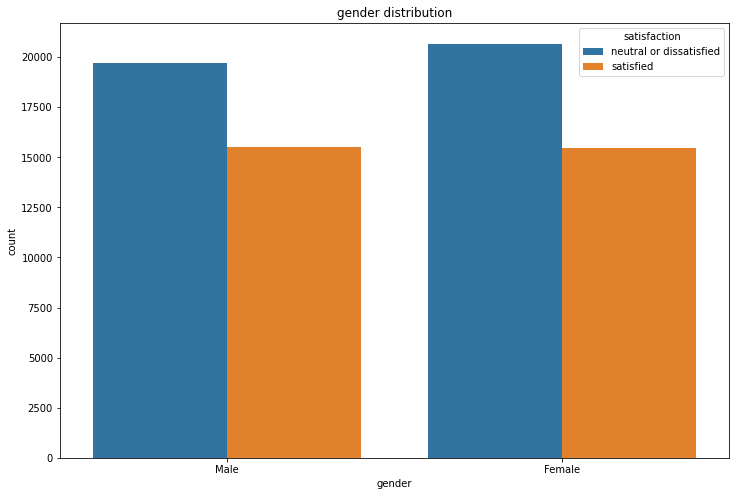

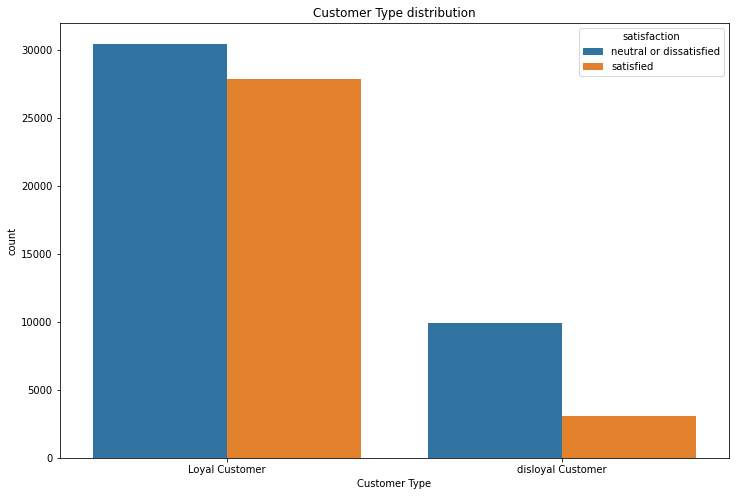

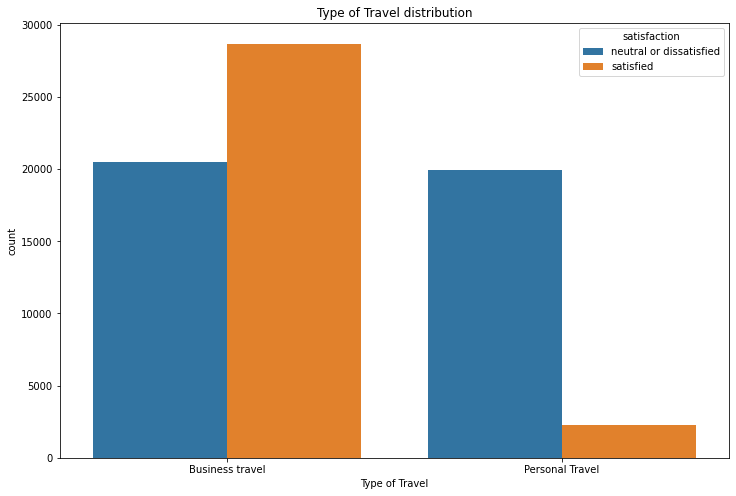

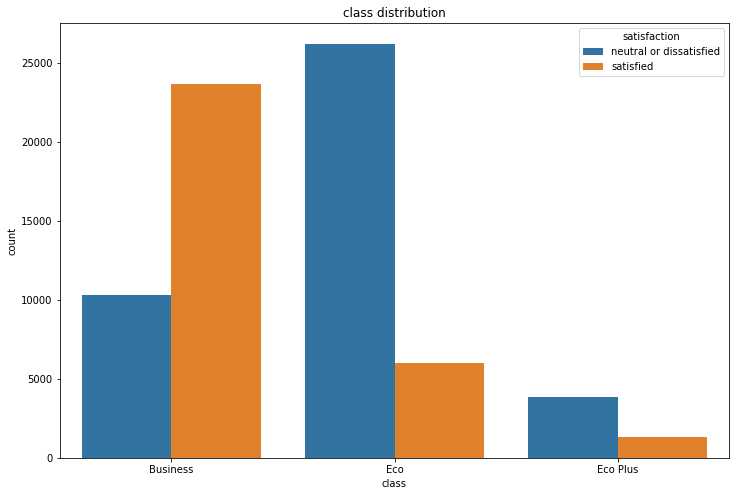

In [ ]:
plot_categorical(categorical_cols, X_train, y_train)

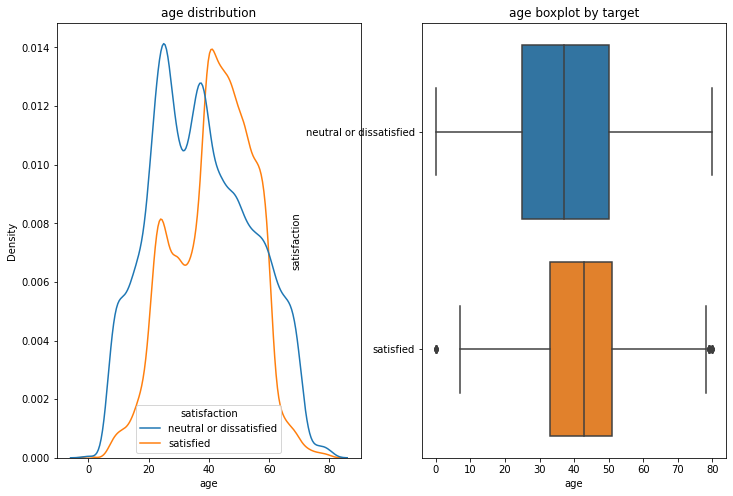

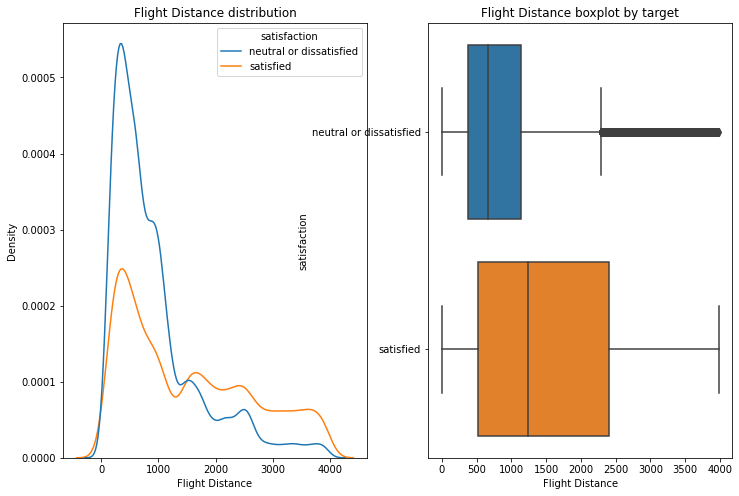

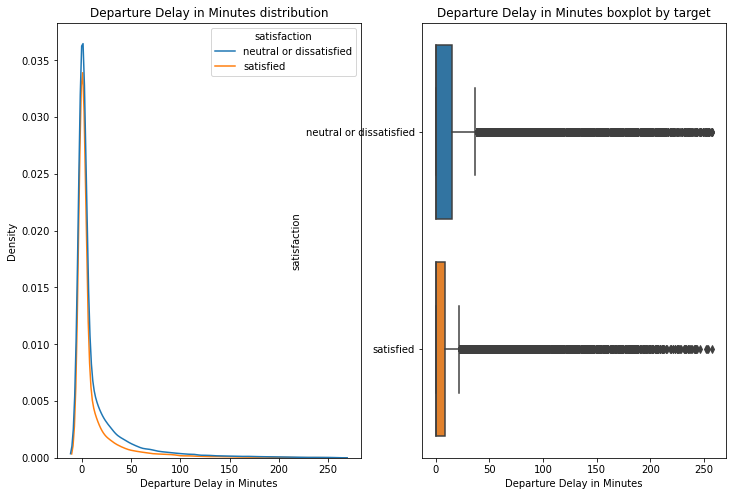

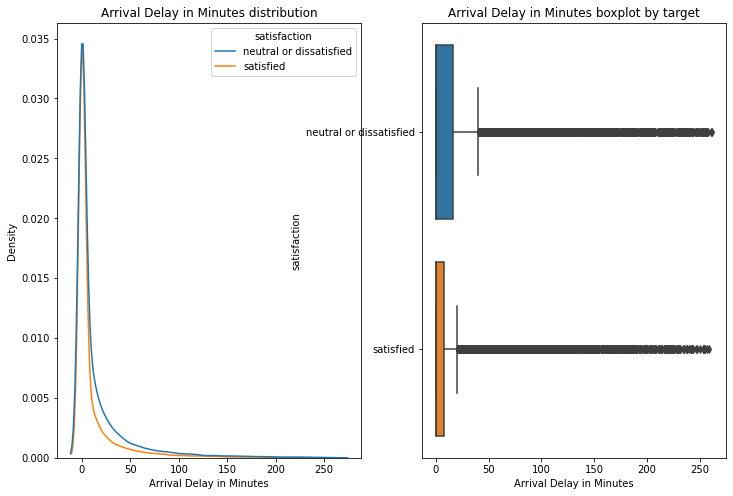

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

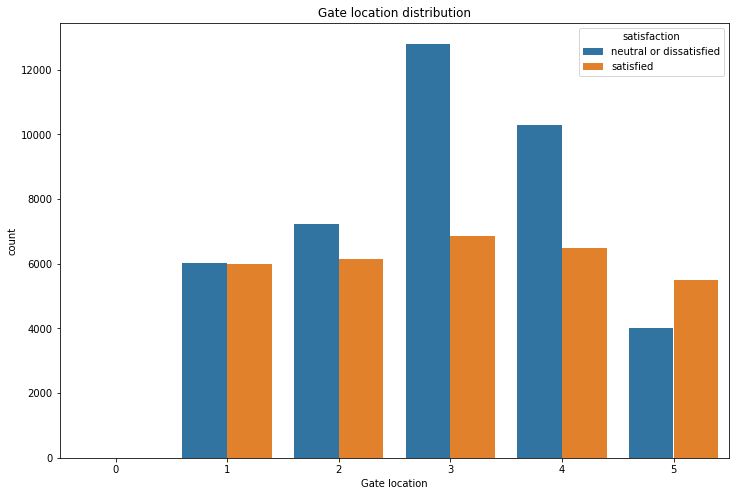

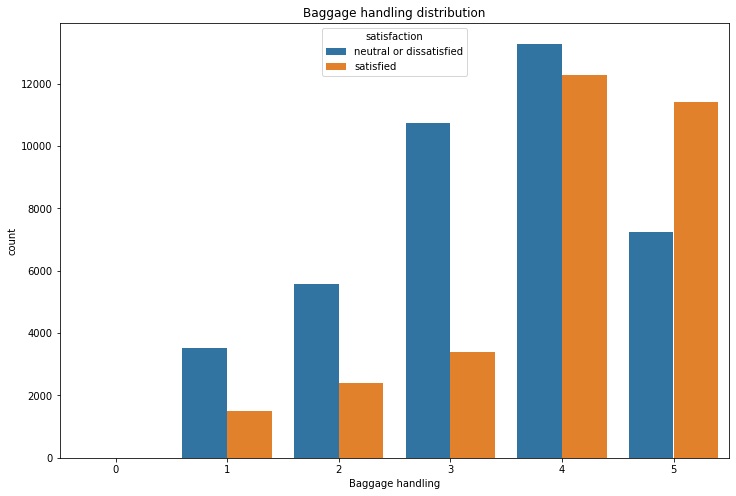

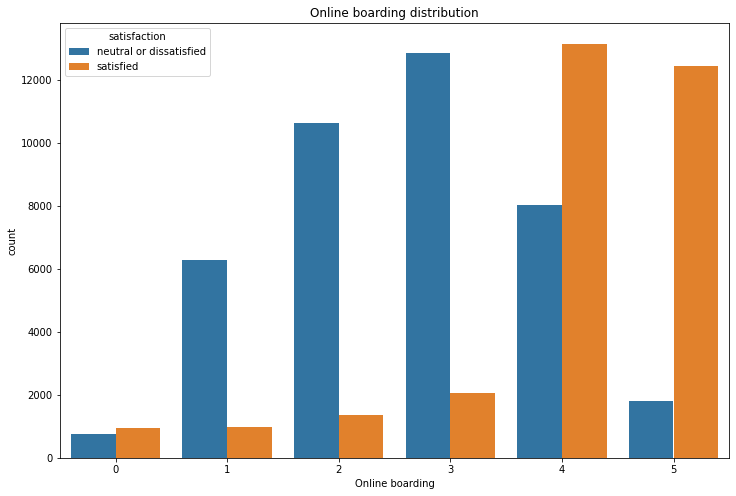

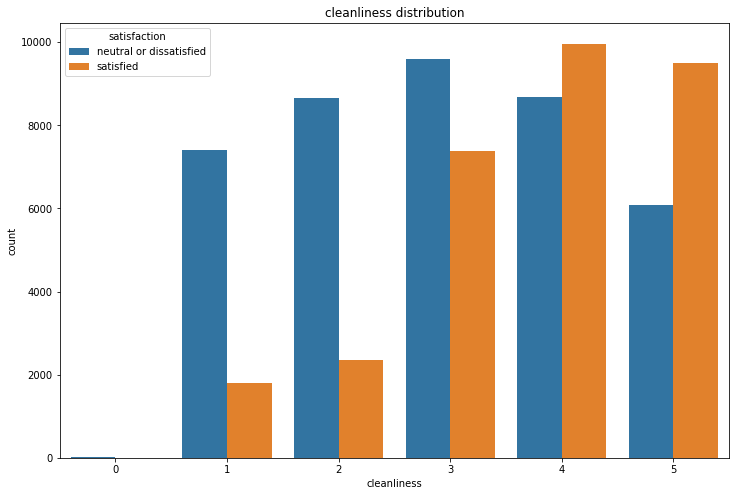

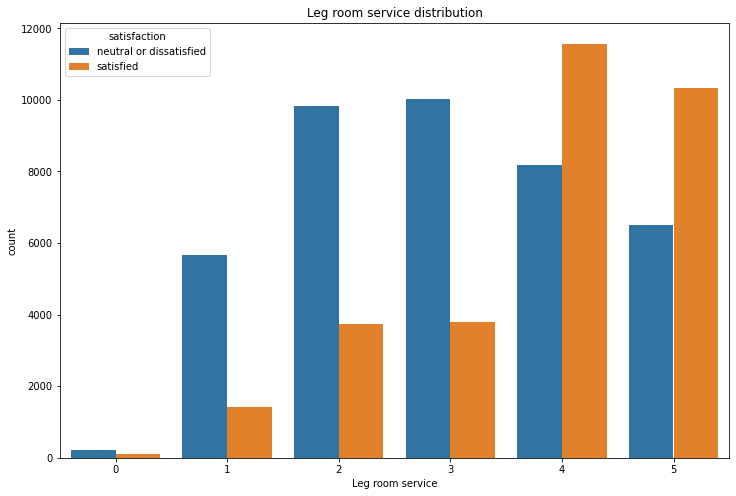

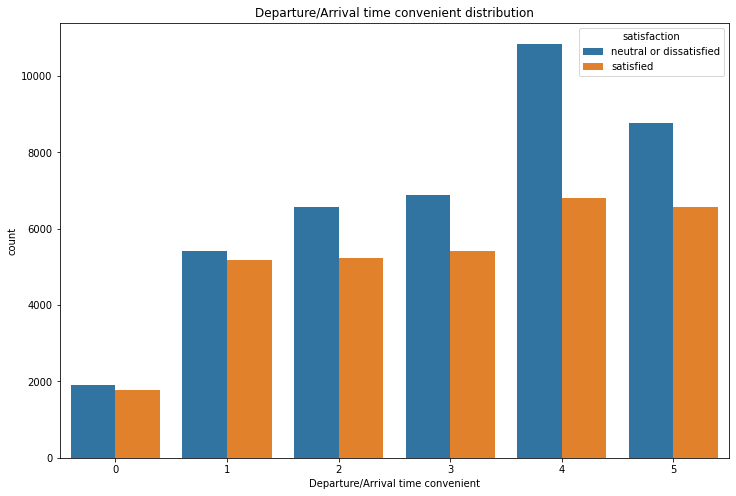

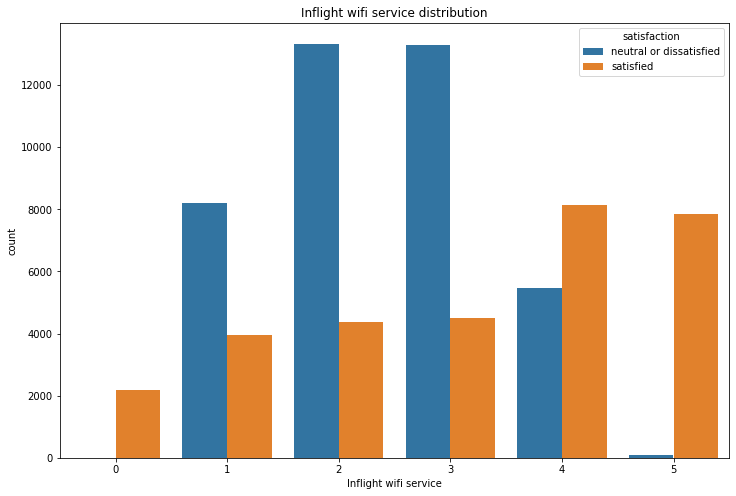

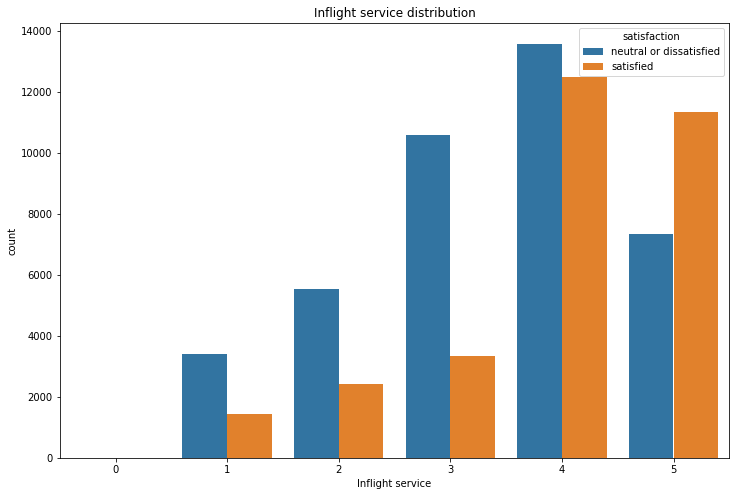

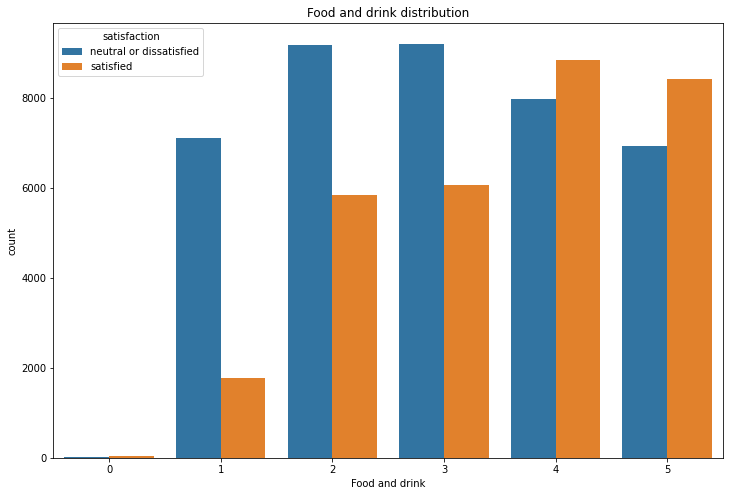

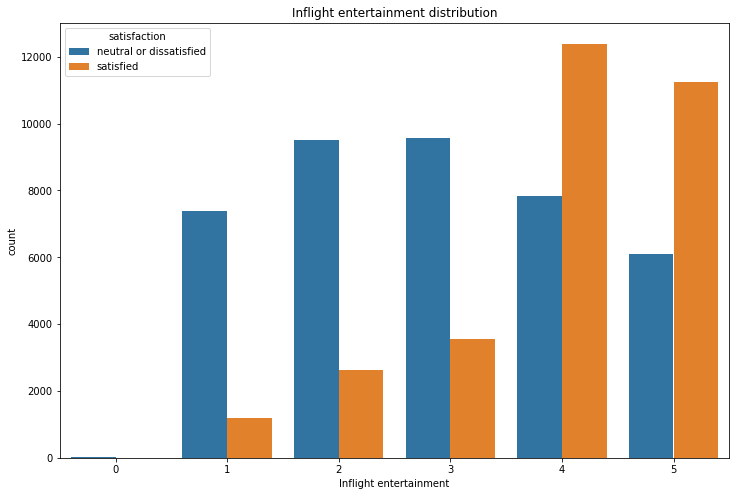

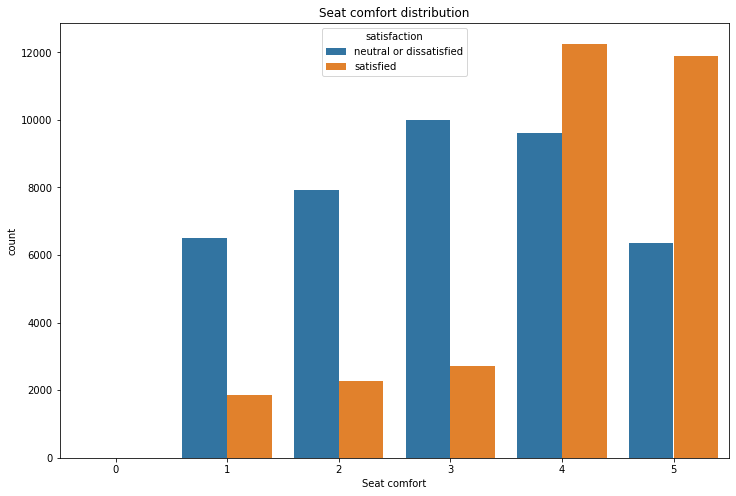

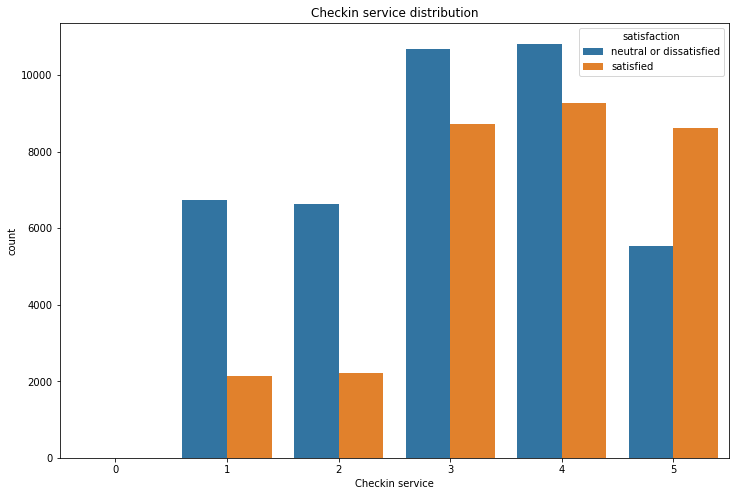

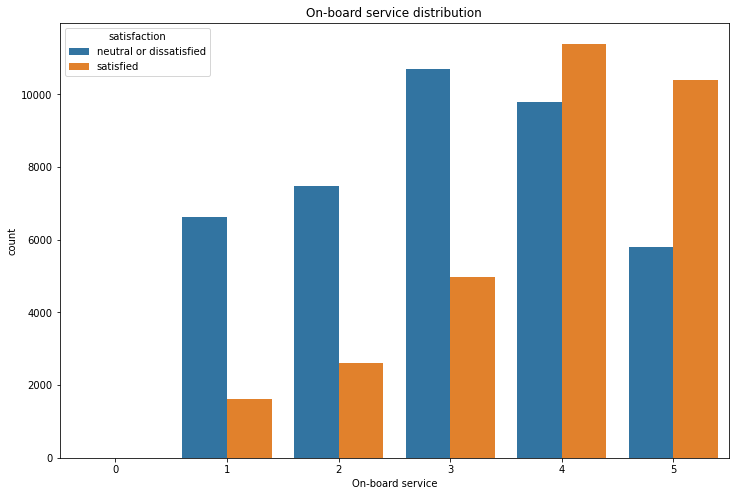

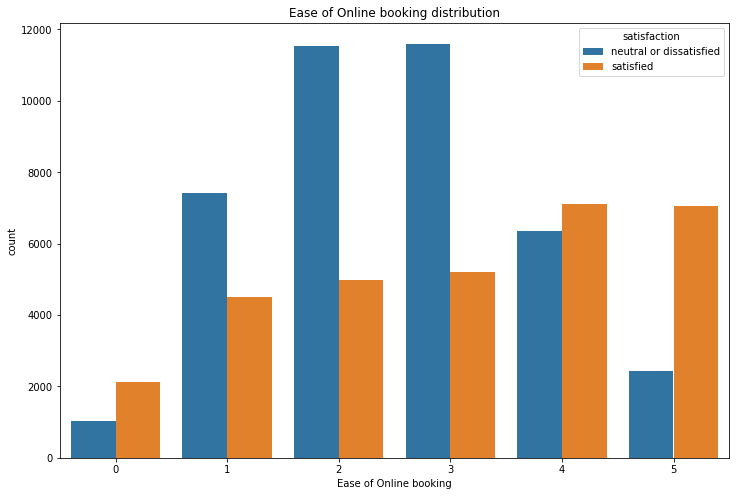

In [ ]:
plot_ordinal(ordinal_cols, X_train, y_train)

In [ ]:
# visualize y_train



<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

In [ ]:
# your answer her
# feel free to change this cell from code to markdown



(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

In [ ]:
# your code below



(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [ ]:
# your code



X does not have valid feature names, but FunctionTransformer was fitted with feature names


Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

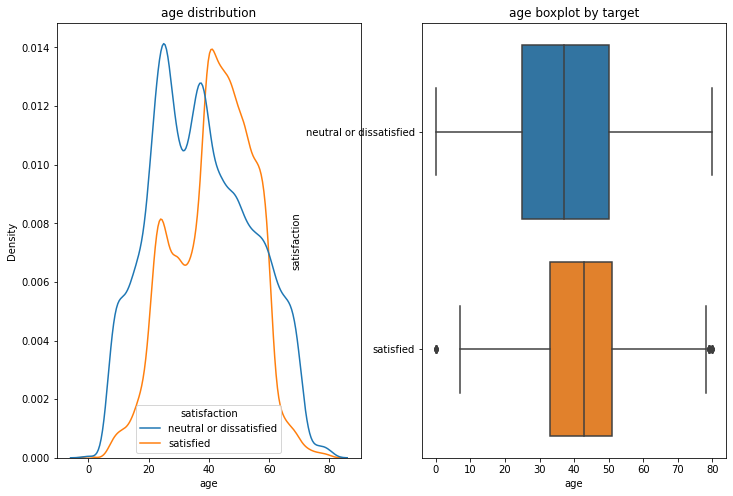

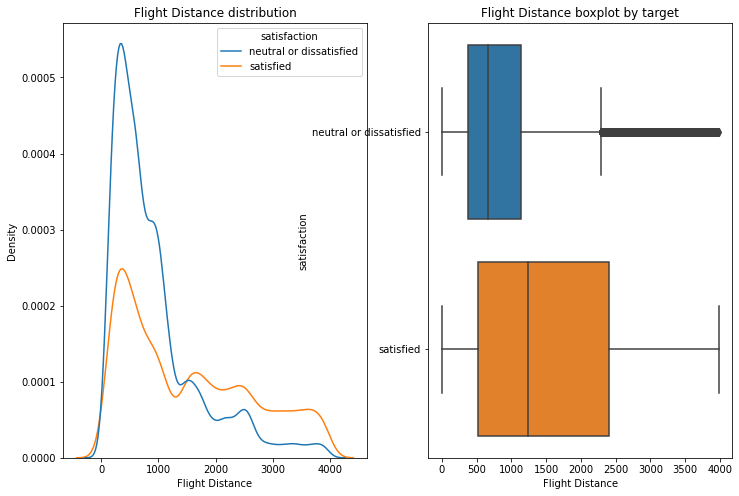

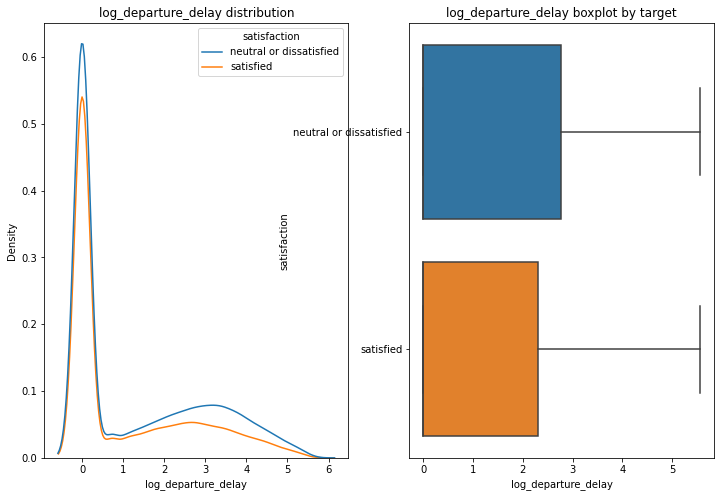

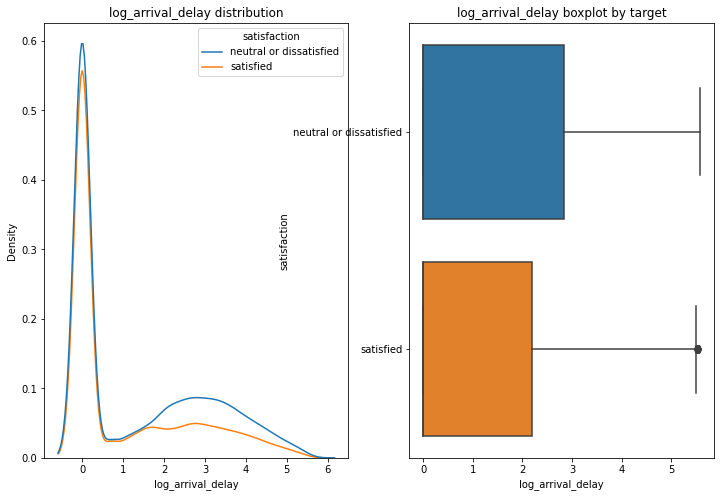

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [ ]:
# your code


(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

<Figure size 1440x1440 with 0 Axes>

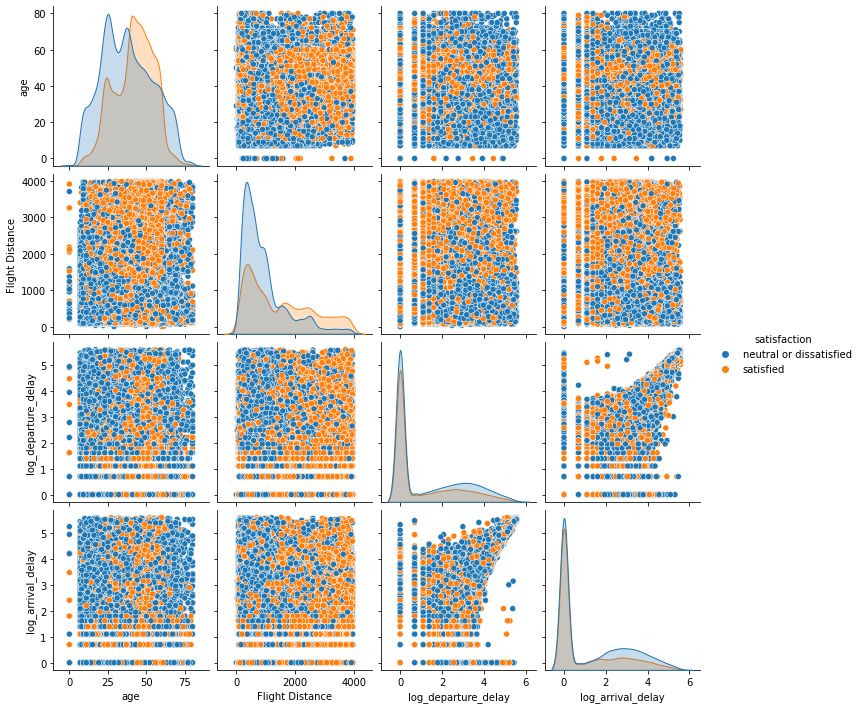

In [ ]:
# your code



# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [ ]:
# your code below



<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [ ]:
# code here



## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
# change *params into what needs to be there by task condition

error_dt, bias_dt, var_dt = bias_variance_decomp(*params)
error_dt, bias_dt, var_dt

(0.060881557990250496, 0.04088035136830928, 0.04455644577440997)

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

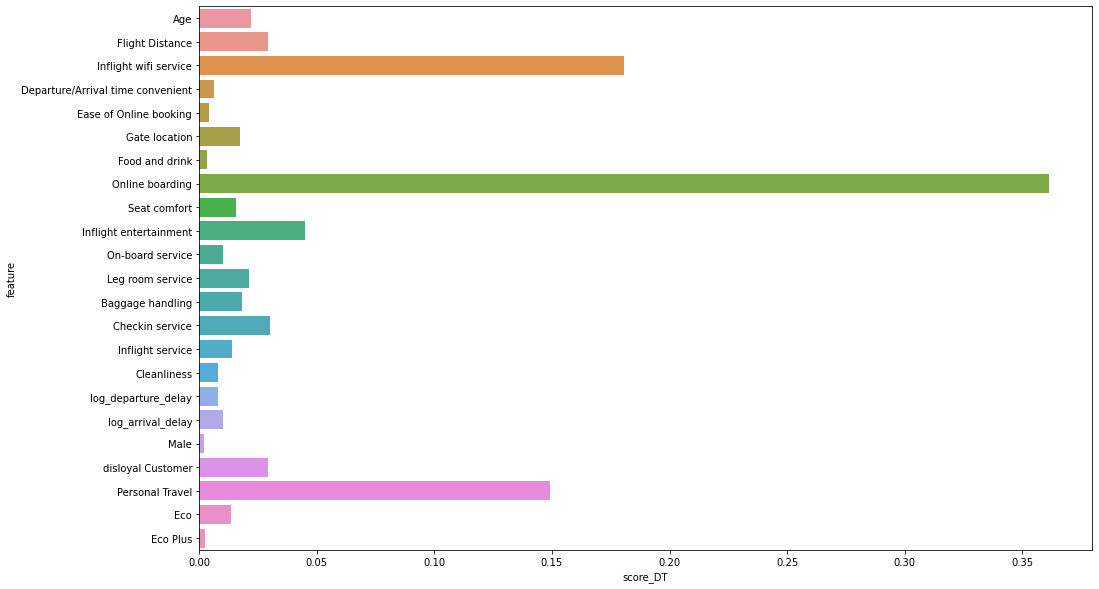

In [ ]:
# the place for your code



<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

In [ ]:
# your answer below
# feel free to change this cell into markdown



<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [ ]:
# the place for your solution



(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

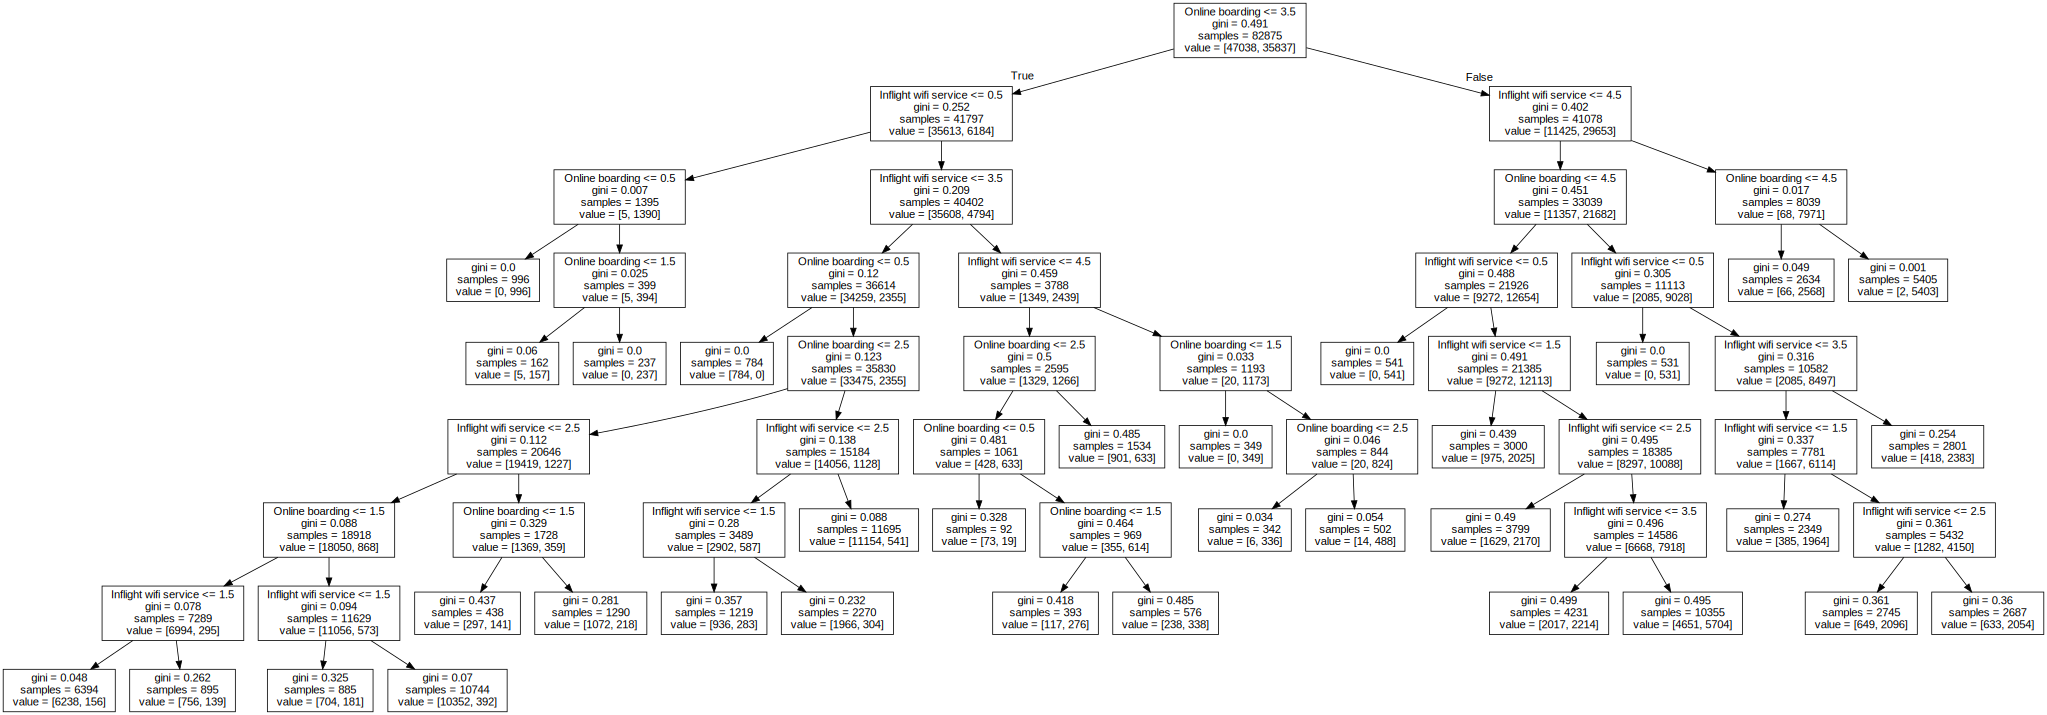

In [ ]:
# feel free to google



<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

In [ ]:
# your code below



(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

<function matplotlib.pyplot.show(*args, **kw)>

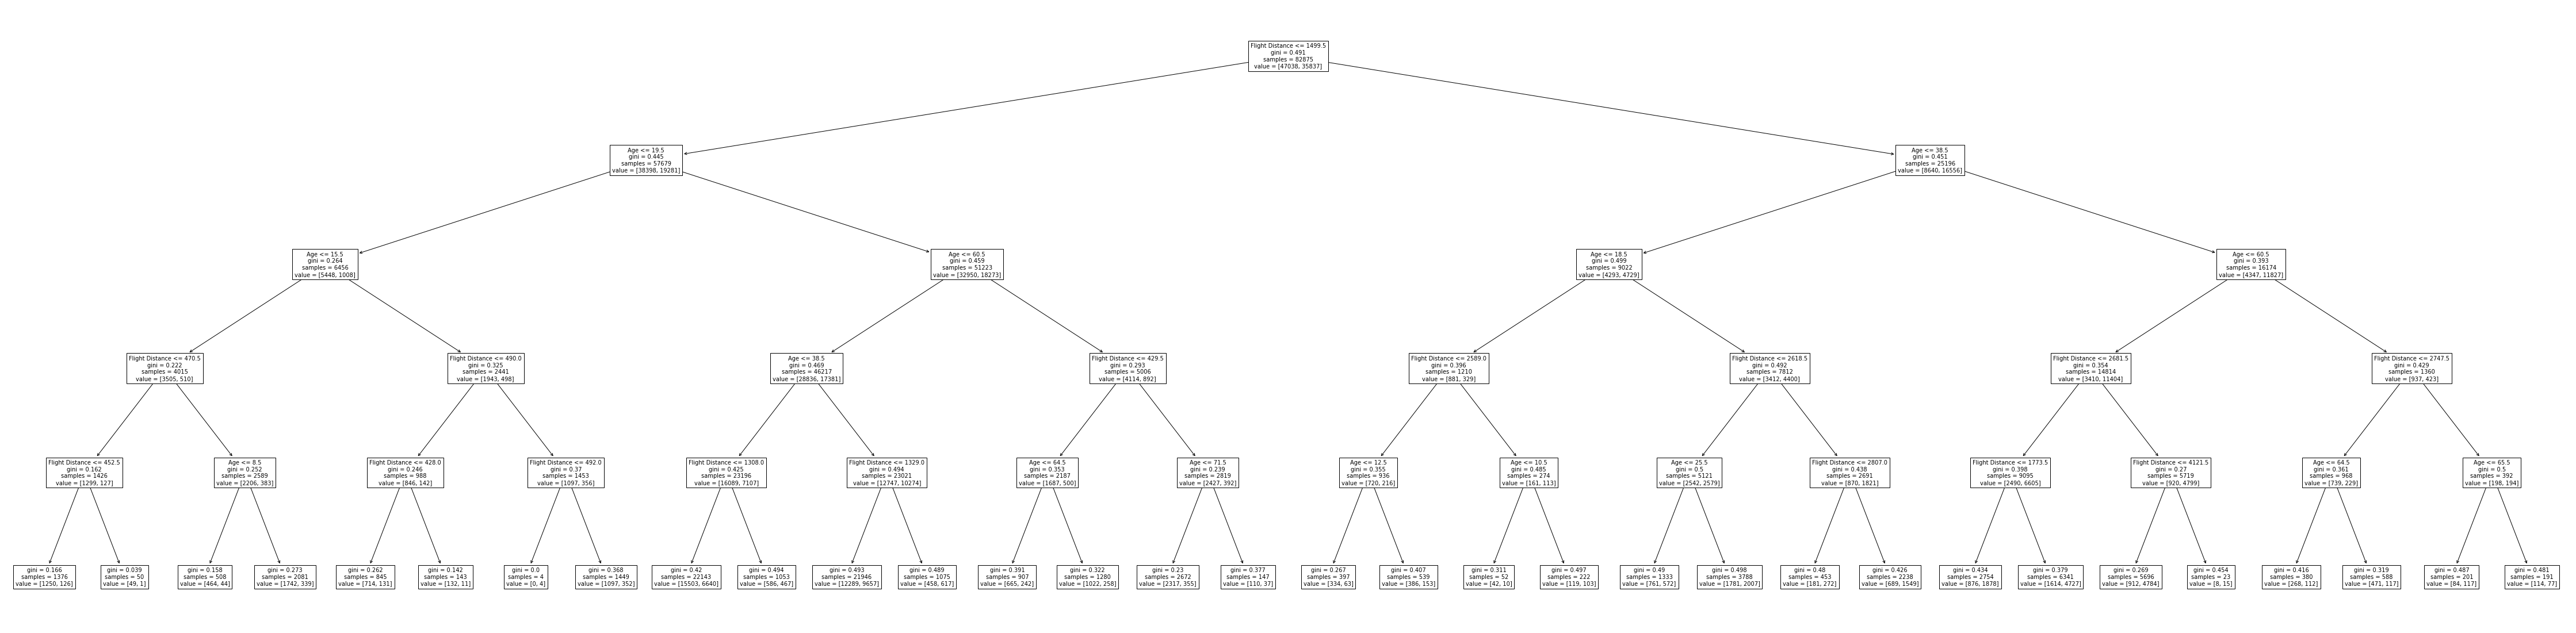

In [ ]:
# another place to code a few lines


(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


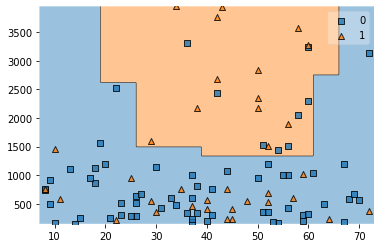

In [ ]:
# your line of code


## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


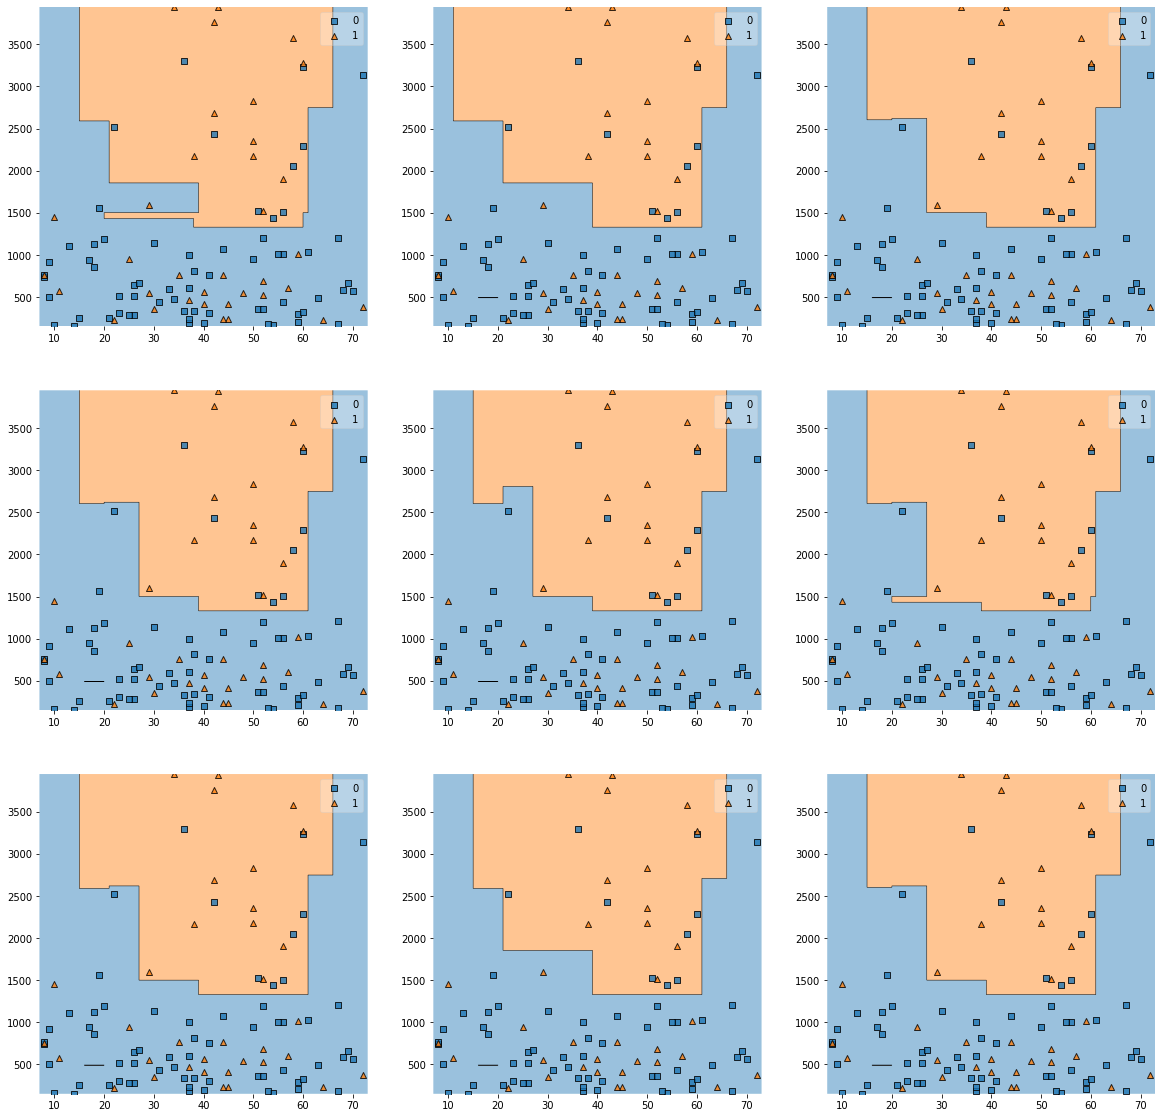

In [ ]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# change X_train_enc into your ohe-encoded train set

%%time 
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

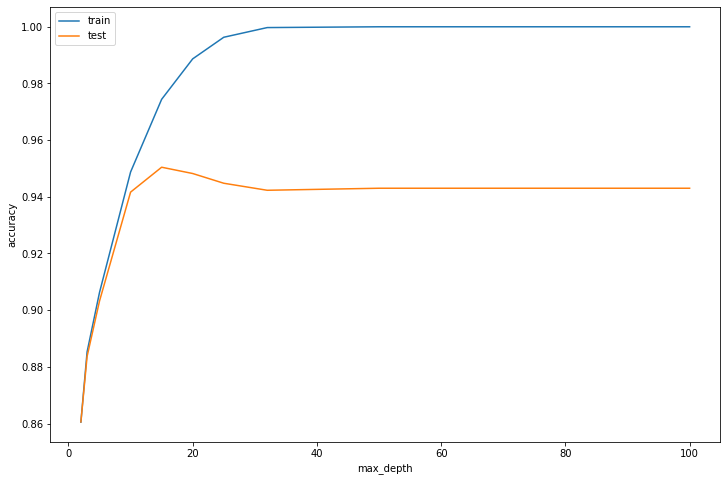

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [ ]:
# you know what to do



<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pass

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [ ]:
# -__-



(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

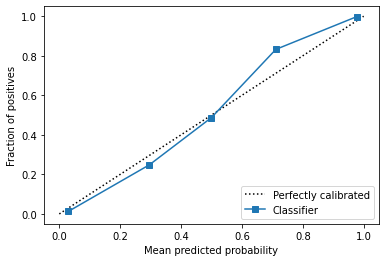

In [ ]:
# some lines of your code



Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

In [ ]:
# your answer below
# feel free to change this cell into markdown



<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

CPU times: user 530 ms, sys: 278 ms, total: 808 ms
Wall time: 431 ms


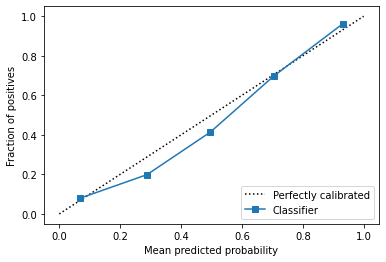

In [ ]:
# --____--



Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

In [ ]:
# maths needed



(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

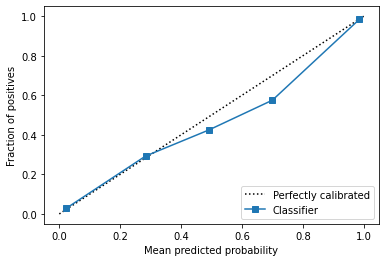

In [ ]:
# yet another code cell for logreg



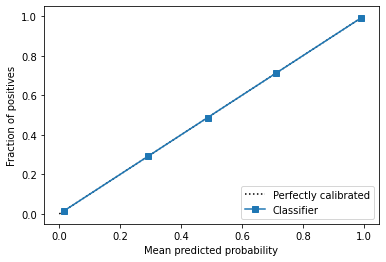

In [ ]:
# yet another code cell for isoreg



<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

In [ ]:
# feel free to change this cell into markdown



(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [ ]:
# one more place for your code



<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [ ]:
# (•_•)


(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# your code here



## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


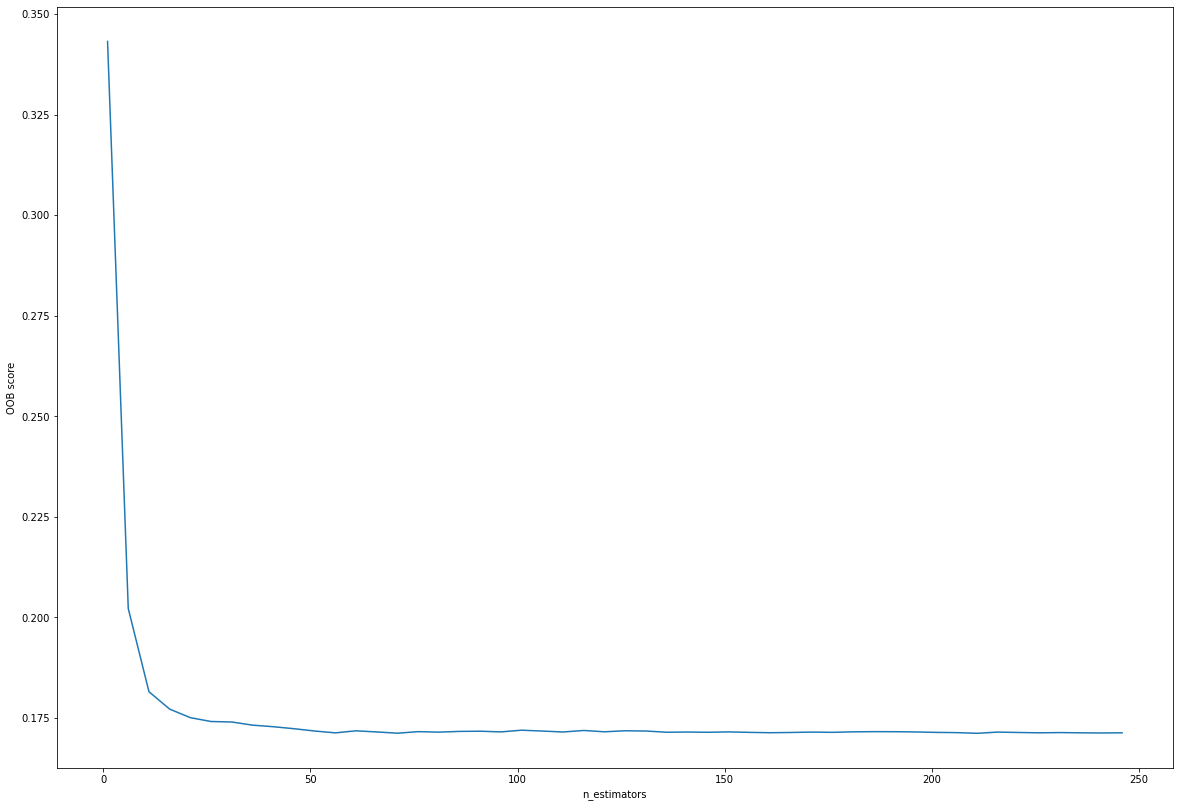

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной 

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

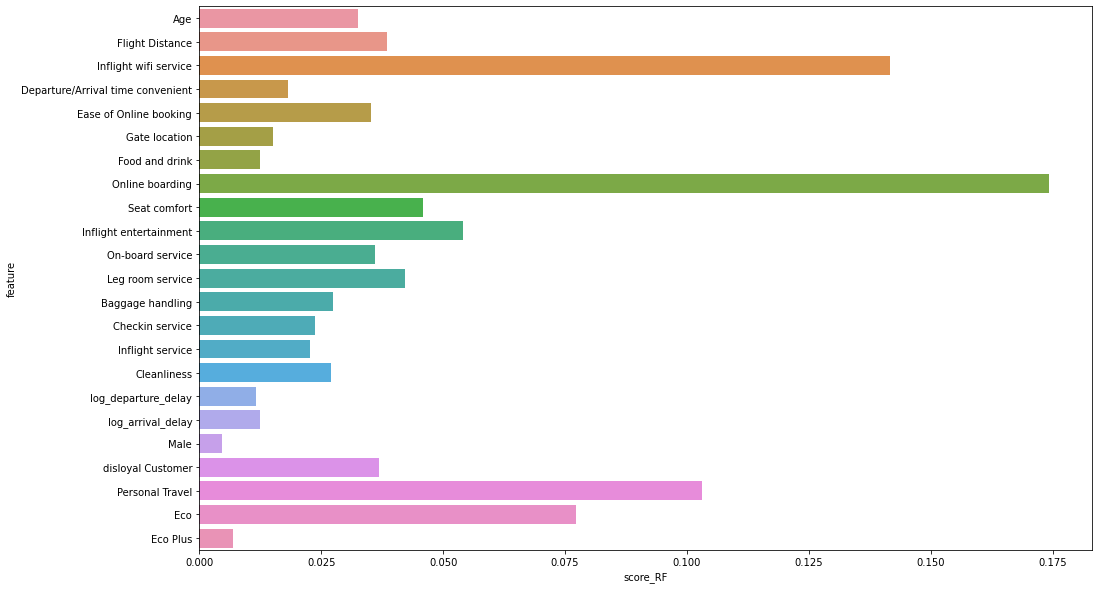

In [ ]:
# (•_•)

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [ ]:
# -__-

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

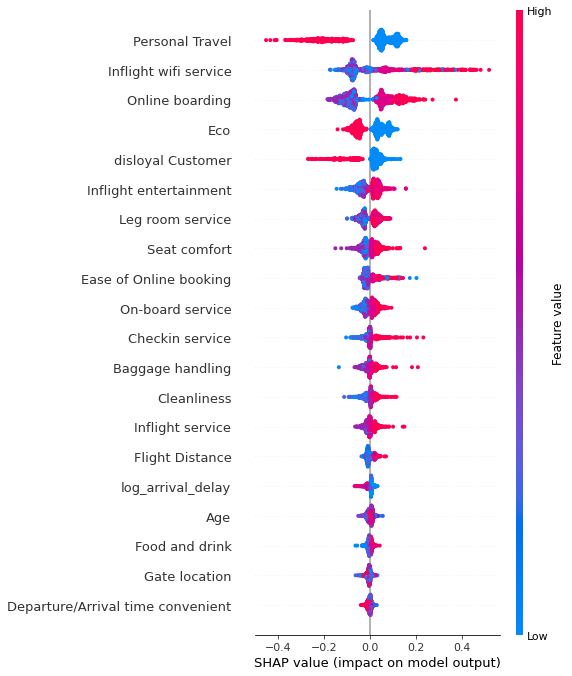

CPU times: user 5min 45s, sys: 2.77 s, total: 5min 47s
Wall time: 5min 45s


In [ ]:
# (•_•)


<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

In [ ]:
# feel free to change this cell into markdown



Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [ ]:
# please type your solution below



X does not have valid feature names, but RandomForestClassifier was fitted with feature names


CPU times: user 13 s, sys: 918 ms, total: 13.9 s
Wall time: 16.1 s


<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?